**Importing the necessary Libraries**

In [77]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

!pip install swifter
import swifter

In [20]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

**Data preparation**

In [21]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [22]:
df.shape

(78313, 22)

In [23]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [24]:
#Assign new column names
df.columns = [re.sub('^_(source.)?',"",column) for column in df.columns]

In [25]:
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [26]:
#Assign nan in place of blanks in the complaints column -- for this checking complaint_what_happened column first
df['complaint_what_happened'].head(20)

0                                                      
1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      
4                                                      
5                                                      
6                                                      
7                                                      
8                                                      
9                                                      
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
12                                                     
13                                                     
14    my grand son give me check for {$1600.00} i de...
15                        Can you please remove inquiry
16                                                     
17    With out notice J.P. Morgan Chase restrict

In [27]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x:np.nan if re.search('^\s*$',x) else x)

In [28]:
df['complaint_what_happened'].head()

0                                                  NaN
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                  NaN
4                                                  NaN
Name: complaint_what_happened, dtype: object

In [29]:
#Remove all rows where complaints column is nan
df= df[~(df['complaint_what_happened'].isnull())]

In [30]:
df.shape

(21072, 22)

# Prepare the text for topic modeling
## Once you have removed all the blank complaints, you need to:


*   Make the text lowercase
*   Remove text in square brackets
*   Remove punctuation
*   Remove words containing numbers

## Once you have done these cleaning operations you need to perform the following:


*   Lemmatize the texts
*   Use POS tags to get relevant words from the texts




In [31]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess(text):
  text = text.lower()
  text = re.sub("\[.*?\]","",text)
  text = "".join([char for char in text if char not in string.punctuation])
  text = re.sub("[^\s]*[\d]+[^\s]*", "", text)
  return text


In [32]:
  complaints = df["complaint_what_happened"].swifter.apply(preprocess)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [33]:
#Write your function to Lemmatize the texts as well as lemmatizing on NOUN Pos Tag
def text_lem_pos(text):
  doc = nlp(text)
  lemma_txt = " ".join([token.lemma_ for token in doc if token.pos_ == 'NOUN'])
  return lemma_txt


In [34]:
lemmatized_complaints = complaints.swifter.apply(text_lem_pos)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [35]:
#Create a dataframe('df_clean') that will have only raw complaints,preprocessed complaints and the lemmatized complaints
df_clean = pd.DataFrame({"raw_complaints" : df["complaint_what_happened"], "preprocessed_complaints" : complaints, "lemmatized_complaints" : lemmatized_complaints})

In [36]:
df_clean

,raw_complaints,preprocessed_complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son chase account fund bank account money son ...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase year banking merchant ...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom xxxx problem ...


# Exploratory data analysis to get familiar with the data.
## Visualising data according to the complaint's character length

In [37]:
complaint_len = df_clean['lemmatized_complaints'].apply(len).value_counts()
complaint_len

95      65
127     63
81      63
73      63
166     62
        ..
1703     1
1655     1
1607     1
1591     1
4282     1
Name: lemmatized_complaints, Length: 1641, dtype: int64

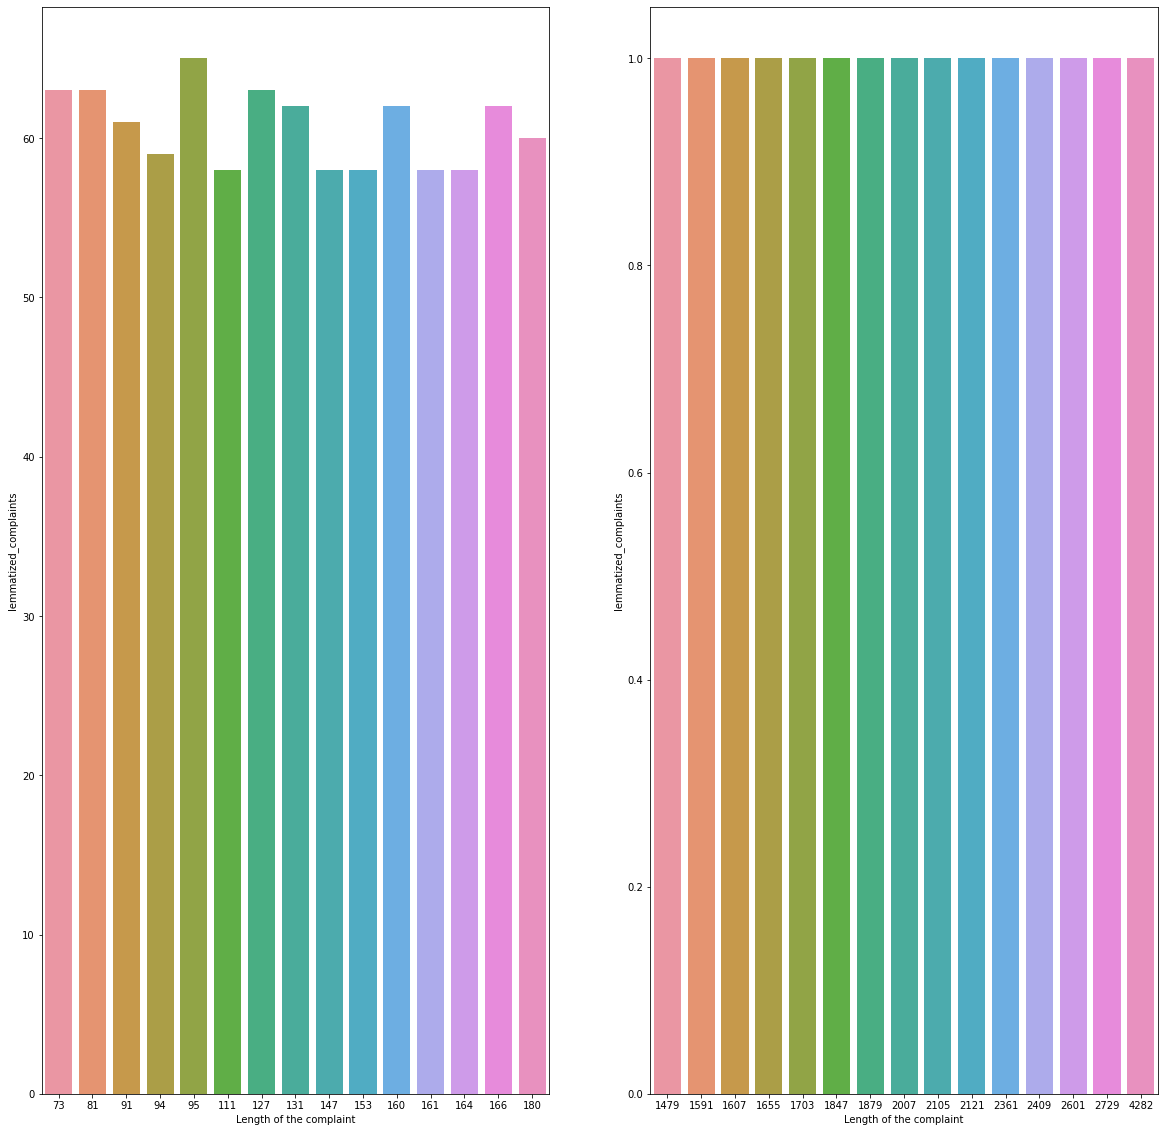

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.xlabel("Length of the complaint")
sns.barplot(x=complaint_len.index[:15],y=complaint_len[:15])
plt.subplot(1,2,2)
plt.xlabel("Length of the complaint")
sns.barplot(x=complaint_len.index[-15:],y=complaint_len[-15:])



*   Most of the complaints are having length>60
*   while there are very less complaints which have length>1000



**Find the top 40 words by frequency among all the articles after processing the text.**

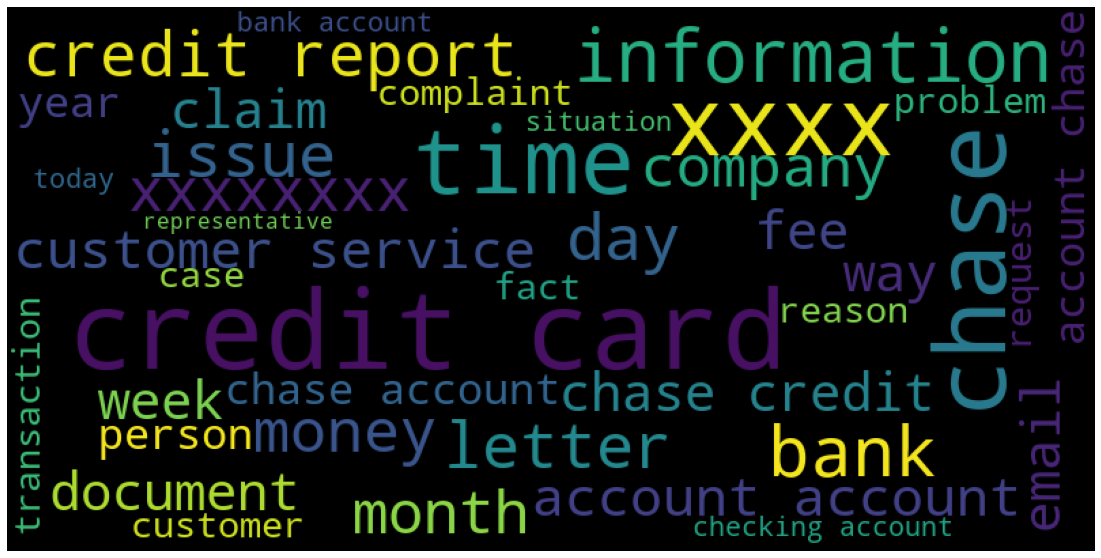

In [39]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      colormap = 'viridis', max_words = 40, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0)
wordcloud.generate(" ".join(df_clean['lemmatized_complaints']))
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Words like Credit card,chase,money, time, account are highly frequent while case,fact,today,reprsentative are less frequent words

In [40]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['lemmatized_complaints'].str.replace('-PRON-', '')

In [41]:
df_clean['Complaint_clean'][1]

'morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help'

**Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [42]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean) -- through count vectorizer[ref:https://www.geeksforgeeks.org/tf-idf-for-bigrams-trigrams/]
def ngram(df,n):
  vectorizer = CountVectorizer(stop_words="english",max_features=5000,ngram_range=(n,n))
  X1 = vectorizer.fit_transform(df)
  features = (vectorizer.get_feature_names_out())
  sums = X1.sum(axis=0)
  data1=[]
  for col,term in enumerate(features):
    data1.append((term, sums[0,col]))
  ranking = pd.DataFrame(data1, columns=['term','rank'])
  words = (ranking.sort_values('rank',ascending=False))
  return words

unigram = ngram(df_clean['Complaint_clean'],1)
unigram.head(30)

,term,rank
26,account,47027
722,chase,37825
1086,credit,32175
617,card,30299
3207,payment,21086
351,bank,16235
4553,time,16003
4966,xxxx,13514
1158,day,12941
710,charge,12114


In [43]:
#Print the top 10 words in the unigram frequency
print(unigram.head(10))

         term   rank
26    account  47027
722     chase  37825
1086   credit  32175
617      card  30299
3207  payment  21086
351      bank  16235
4553     time  16003
4966     xxxx  13514
1158      day  12941
710    charge  12114


In [44]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = ngram(df_clean['Complaint_clean'],2)
print(bigram.head(30))

                  term   rank
1552       credit card  12636
1606     credit report   3831
13     account account   2968
1659  customer service   2892
1062      chase credit   2630
1009     chase account   2568
48       account chase   2465
1284  checking account   2242
454       bank account   2199
1801        debit card   1868
709       card account   1799
1611      credit score   1714
69      account credit   1656
3477   payment payment   1645
1037        chase card   1589
3025     money account   1457
733          card card   1390
739         card chase   1286
750        card credit   1277
3610      phone number   1268
675       business day   1235
149     account number   1227
744       card company   1132
938     charge account   1129
2293      fund account   1084
3196  mortgage payment   1068
31        account bank   1050
4154    saving account   1048
30     account balance   1035
3403   payment account   1017


In [45]:
#Print the top 10 words in the bigram frequency
print(bigram.head(10))

                  term   rank
1552       credit card  12636
1606     credit report   3831
13     account account   2968
1659  customer service   2892
1062      chase credit   2630
1009     chase account   2568
48       account chase   2465
1284  checking account   2242
454       bank account   2199
1801        debit card   1868


In [46]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigrams = ngram(df_clean['Complaint_clean'],3)
print(trigrams.head(30))

                                 term  rank
1699                chase credit card  1920
2225              credit card account  1054
2259              credit card company   974
2265               credit card credit   629
2253                credit card chase   570
3295            inquiry credit report   554
1173                 card credit card   521
242               account credit card   478
1498               charge credit card   399
2531          credit reporting agency   383
2482             credit report credit   375
252             account credit report   351
2330              credit card payment   345
2247                 credit card card   327
2621  customer service representative   326
2530             credit reporting act   314
162             account chase account   302
1717           chase customer service   291
2236              credit card balance   281
2252               credit card charge   273
2024          checking saving account   257
3959              payment credit

In [47]:
#Print the top 10 words in the trigram frequency
print(trigrams.head(10))

                         term  rank
1699        chase credit card  1920
2225      credit card account  1054
2259      credit card company   974
2265       credit card credit   629
2253        credit card chase   570
3295    inquiry credit report   554
1173         card credit card   521
242       account credit card   478
1498       charge credit card   399
2531  credit reporting agency   383


The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [48]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [49]:
#All masked texts has been removed
df_clean

,raw_complaints,preprocessed_complaints,lemmatized_complaints,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son chase account fund bank account money son ...,son chase account fund bank account money son ...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,card provider claim purchase protection benefi...,card provider claim purchase protection benefi...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,pay risk consumer chase year banking merchant ...,pay risk consumer chase year banking merchant ...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yrs ive had ch...,credit credit card chase freedom xxxx problem ...,credit credit card chase freedom problem bala...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [50]:
#Write your code here to initialise the TfidfVectorizer
vectorizer1 = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english", ngram_range = (1,3), max_features = 10000)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [51]:
term_document= vectorizer1.fit_transform(df_clean['Complaint_clean'])

In [52]:
words = np.array(vectorizer1.get_feature_names_out())
print(len(words))

10000


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [53]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state = 40)#write your code here

In [54]:
W = nmf_model.fit_transform(term_document) #Document-Topic Matrix
H = nmf_model.components_   #Topic-Term Matrix
len(vectorizer1.get_feature_names_out())

10000

In [55]:
#Print the Top15 words for each of the topics

topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype("str")
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,transaction,day,branch,deposit,account account,claim,number,checking,fee
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,company,service,merchant,time,card card,balance
Topic 3,loan,mortgage,home,modification,chase,property,year,document,rate,time,letter,sale,loan modification,foreclosure,house
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,account,score,debt,report credit,reporting,account credit,information,credit report credit,identity
Topic 5,payment,payment payment,balance,fee,month,statement,payment account,account payment,payment chase,payment month,credit,payment credit,time,chase payment,day


In [ ]:
# It seems Topic 1 is related to Bank Account Services, 
#Topic 2 with words like Credit,score,card,limit,offer and all seems to be Credit card/Prepaid
# while Topic 3 seems to be Mortgages/Loans with words as Loan,Mortgage,fee,rate,property,modification and all
# Topic 4 and Topic 5 seems to be Theft/Dispute reporting with words as theft,dispute,application,fraud,claim,identity etc.

In [56]:
# Let's increase num_topics to 7 and see what we find
#Load your nmf_model with the n_components i.e 7
num_topics = 7 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state = 40)#write your code here

In [57]:
W = nmf_model.fit_transform(term_document) #Document-Topic Matrix
H = nmf_model.components_   #Topic-Term Matrix

In [58]:
#Print the Top20 words for each of the topics
#words = np.array(vectorizer1.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 20)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(20)]).astype("str")
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:20]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
Topic 1,account,money,bank,account account,chase,fund,branch,checking,transaction,fee,deposit,chase account,checking account,bank account,day,number,account chase,transfer,saving,business
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card credit,card card,balance,card account,card chase,score,limit,chase card,year,point,credit card account,credit card credit,card company,credit score
Topic 3,loan,mortgage,home,modification,property,chase,year,rate,document,loan modification,time,foreclosure,sale,house,letter,debt,process,application,information,income
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,reporting,debt,company,credit report credit,identity,score,credit reporting,account credit,credit inquiry,report inquiry,account credit report,theft
Topic 5,payment,payment payment,balance,fee,month,statement,payment account,account payment,time,payment month,payment chase,day,chase payment,payment credit,payment time,date,auto,month payment,chase,credit
Topic 6,check,bank,fund,check check,money,check account,deposit,day,account check,check bank,branch,check chase,bank check,hold,chase,cashier,business,chase check,check fund,cashier check
Topic 7,charge,dispute,transaction,merchant,chase,claim,fraud,email,service,company,time,purchase,card,day,refund,phone,letter,charge charge,information,number


In [ ]:
# Topic 1 - Bank Account Services/Others
# Topic 2 - Credit Card/Prepaid
# Topic 3 - Mortgages/Loans, Topic 5 -- same as 3
# Topic 4 - Theft/Dispute reporting, Topic 7 -- same as 4
# Topic 6 - either Bank Account Services or Others

In [ ]:
# Let's try with 9 topics and 20 words for each topics

In [59]:
#Load your nmf_model with the n_components i.e 9
num_topics = 9 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state = 40)#write your code here

In [60]:
W = nmf_model.fit_transform(term_document) #Document-Topic Matrix
H = nmf_model.components_   #Topic-Term Matrix

In [61]:
#Print the Top20 words for each of the topics
#words = np.array(vectorizer1.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 20)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(20)]).astype("str")
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:20]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
Topic 1,account,account account,checking,chase account,chase,account chase,checking account,saving,saving account,deposit,branch,reason,bank account,fund,account credit,business,letter,balance,information,account number
Topic 2,card,credit,credit card,chase,chase credit,chase credit card,card credit,card card,card account,balance,card chase,score,chase card,limit,point,credit card credit,card company,year,credit score,credit card account
Topic 3,loan,mortgage,home,modification,property,chase,year,rate,document,loan modification,foreclosure,sale,letter,house,time,debt,process,application,income,loan loan
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,report credit,information,reporting,company,credit report credit,debt,identity,credit inquiry,score,report inquiry,credit reporting,account credit,theft,account credit report
Topic 5,payment,payment payment,month,balance,payment account,statement,account payment,payment month,payment chase,payment credit,chase payment,day,time,credit,payment time,auto,month payment,mortgage payment,chase,date
Topic 6,check,fund,check check,bank,check account,deposit,account check,check bank,day,check chase,bank check,branch,hold,cashier,money,chase,chase check,check fund,business,cashier check
Topic 7,money,bank,transaction,claim,number,chase,day,fraud,phone,fund,atm,debit,branch,email,customer,time,debit card,person,transfer,information
Topic 8,fee,overdraft,overdraft fee,balance,fee fee,fee account,transaction,account fee,transfer,year,card fee,fee chase,month,statement,fund fee,customer,time,dollar,fee charge,fund
Topic 9,charge,dispute,merchant,chase,charge charge,fraud,charge account,company,letter,charge chase,purchase,statement,refund,service,chase charge,card charge,item,email,time,charge credit


In [ ]:
# Credit Card/Prepaid -- Topic 2
# Bank Account Services -- Topic 6,7
# Theft/Dispute Reporting -- Topic 4,9
# Mortgages/Loans -- Topic 5
# Others -- Topic 1,3,8

# Since the entire dataset seems to revolve around these 5 topics, the ones mentioned here so, will go with num_topics as 5;

In [62]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components = num_topics,random_state = 40)#write your code here

W = nmf_model.fit_transform(term_document) #Document-Topic Matrix
H = nmf_model.components_

words = np.array(vectorizer1.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype("str")
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,transaction,day,branch,deposit,account account,claim,number,checking,fee
Topic 2,card,credit,credit card,charge,chase,dispute,chase credit,purchase,chase credit card,company,service,merchant,time,card card,balance
Topic 3,loan,mortgage,home,modification,chase,property,year,document,rate,time,letter,sale,loan modification,foreclosure,house
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,account,score,debt,report credit,reporting,account credit,information,credit report credit,identity
Topic 5,payment,payment payment,balance,fee,month,statement,payment account,account payment,payment chase,payment month,credit,payment credit,time,chase payment,day


In [63]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
best_topics = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
best_topics['max_topic'] = best_topics.apply(lambda x: np.argmax(x), axis = 1)
best_topics[pd.notnull(best_topics['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.017982,0.004554,0.013575,0.010404,0.005534,0
1,0.007763,0.014481,0.004630,0.000768,0.001463,1
2,0.000000,0.030906,0.000000,0.023626,0.000000,1
3,0.011001,0.022262,0.009411,0.058792,0.000000,3
4,0.057307,0.000000,0.000000,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.120558,0.000000,3
6,0.054375,0.003933,0.004291,0.000000,0.010836,0
7,0.002897,0.006293,0.033990,0.000000,0.049385,4
8,0.033023,0.018123,0.017230,0.007736,0.001837,0
9,0.000000,0.053662,0.000000,0.068503,0.000000,3


In [64]:
# here, 0 refers to Topic 1, 1 refers to Topic 2, 3 refers to Topic 4, 2 refers to Topic 3 and 4 refers to Topic 5
best_topics['max_topic'].shape

(21072,)

In [65]:
best_topics['max_topic'].dtype

dtype('int64')

In [66]:
#Assign the best topic to each of the complaints in Topic Column
df_clean['Topic']= best_topics['max_topic'].values

In [67]:
df_clean.head(5)

,raw_complaints,preprocessed_complaints,lemmatized_complaints,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,son chase account fund bank account money son ...,son chase account fund bank account money son ...,0


In [68]:
#Print the first 5 Complaint for each of the Topics
pd.set_option("max_colwidth",None)
df_clean.groupby('Topic').head(5).sort_values(by ='Topic')

,raw_complaints,preprocessed_complaints,lemmatized_complaints,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
24,mishandling of this account by Chase auto and XXXX.,mishandling of this account by chase auto and xxxx,account,account,0
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,son chase account fund bank account money son check money bank money son time check owner country time date check number xxxx claim number,son chase account fund bank account money son check money bank money son time check owner country time date check number claim number,0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment to an online retailer using Chase quick pay with XXXX on the Chase website. I realized that this was a scam website after no confirmation, product, or response to any inquiries regarding the order and contacted Chase to get more information about the transaction to attempt getting a refund through the retailers bank. \n\nI contacted Chase via a secured message on XX/XX/2019 explaining what happened and asked "" Is there a way to reverse this transaction, or do you have a contact at XXXX that can give me more information about the recipient? '' That XXXX, my message was reviewed and I received a response restating my original email and informing me that "" The transfer has been completed. However, as you mentioned that the website is a scam while we can handle most inquiries by email, some require the expertise of another team. In order to assist you better in regards to the refund we request you to call our Consumer Online Technical Support Team. '' I called the number listed in the email and explained my situation to then be transferred to the claims department. I was directed to call XXXX and ask them about the transaction because Chase did not have any information outside of what I provided when initiating the transfer. I fel

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [69]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account Services",1:"Credit card or prepaid card",2:"Mortgage/Loan",3:"Others",4:"Theft/Dispute Reporting"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [70]:
df_clean

,raw_complaints,preprocessed_complaints,lemmatized_complaints,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Bank Account Services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,Credit card or prepaid card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithsta

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [71]:
#Create the dictionary again of Topic names and Topics

Topic_ids = {"Bank Account Services": 0, "Credit card or prepaid card": 1,"Mortgage/Loan": 2,"Others": 3,"Theft/Dispute Reporting": 4}
#Replace Topics with Topic IDs
df_clean['Topic']= df_clean['Topic'].map(Topic_ids)

In [72]:
df_clean

,raw_complaints,preprocessed_complaints,lemmatized_complaints,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,card agent anniversary date agent information order account anniversary date consent xxxx recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contra

In [73]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['Complaint_clean','Topic']]

In [74]:
training_data

,Complaint_clean,Topic
1,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,card agent anniversary date agent information order account anniversary date consent recording agent,1
10,card application identity consent service credit identity applicant,1
11,ticket offer ticket reward card information offer minute screen decision bank notification screen application information offer credit offer account statement ticket account application representative application request application contrary fact credit account name credit report chase information credit report application error,3
14,son chase account fund bank account money son check money bank money son time check owner country time date check number claim number,0
...,...,...
78303,chase card customer decade solicitation credit card chase bonus airline mile hotel point card fee year month payment chase card card chase harm credit fee account point airline hotel enrollment credit airline charge,1
78309,card provider claim purchase protection benefit school textbook year daughter school book water bottle backpack chase representative textbook claim website claim paperwork copy credit card statement copy receipt evidence damage website book catagorie type item claim claim insurance provider information business day step process email claim submission representative claim examiner day day claim information information writing email adjuster adjuster hold file hold claim textbook life revision course daughter course chase textbook purchase claim time call email claim status,1
78310,pay risk consumer chase year banking merchant merchant inquiry communication website merchant face brand individual medium consent research phone number information merchant account title holder cycle fraud voip identity report report recourse matter protocol place issue verbiage point app branch degree entitlement customer service protection protocol back link consumer risk service concern chase minimum risk banking app public plan report authority individual identity neighbor television news network risk banking app public fraud scamming banking mogul chase recourse action risk extent,3
78311,credit credit card chase freedom problem balance transfer life plenty experience balance transfer chase freedom chase card freeedom bill minimum payment representative payment balance transfer fee front payment balance rate payment payment chase representative standard user agreement paperwork year world card chase amt credit card kid bill chart payment percentage paperwork term term payment transfer fee balance card payment chase slate card person credit card lump sum,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [108]:
# Tfidf Vector Transform from Count Vectorizer Ref : https://pythonclass.in/sklearn-tfidfvectorizer.php#:~:text=Tfidfvectorizer%20is%20called%20the%20transform%20to%20normalize%20the,in%20information%20which%20is%20found%20good%20to%20use.
vectorizer3 = CountVectorizer(ngram_range = (1,3),max_features = 10000)
counts = vectorizer3.fit_transform(df_clean['Complaint_clean'])

In [88]:
Tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
Tfidf_vect = Tfidf_transformer.fit(counts)

In [90]:
Count_vec = vectorizer3.transform(df_clean['Complaint_clean'])
Tfidf_vec = Tfidf_transformer.transform(Count_vec)

In [91]:
#Splitting into test and train split
X_train,X_test,y_train,y_test = train_test_split(Tfidf_vec,df_clean['Topic'],test_size=0.2,random_state=100)

In [93]:
X_train.shape,X_test.shape

((16857, 10000), (4215, 10000))

In [ ]:
#Splitting into test and train split
#X_train,X_test,y_train,y_test = train_test_split(df_clean['Complaint_clean'],df_clean['Topic'],test_size=0.2,random_state=100)

In [ ]:
#vectorizer2 = TfidfVectorizer(ngram_range = (1,3), max_features = 10000)
#X_train = vectorizer2.fit_transform(X_train).toarray()
#X_test = vectorizer2.fit_transform(X_test).toarray()

In [ ]:
#X_train.shape,X_test.shape

((16857, 10000), (4215, 10000))

In [94]:
# Looking at the class distribution of the y_train
y_train.value_counts()/len(y_train)

1    0.304621
0    0.290562
2    0.173518
4    0.123925
3    0.107374
Name: Topic, dtype: float64

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [112]:
# First, using Naive Bayes
model1 = MultinomialNB()
model1.fit(X_train,y_train)

MultinomialNB()

In [127]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)
clf_report = classification_report(y_test,y_test_pred)
print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
print("Classification report on test data :",clf_report,sep="\n")

Accuracy score on train data : 0.8931007889897372
Accuracy score on test data : 0.8581257413997627

Classification report on test data :
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1218
           1       0.83      0.93      0.88      1261
           2       0.87      0.88      0.88       729
           3       0.88      0.78      0.83       473
           4       0.93      0.58      0.72       534

    accuracy                           0.86      4215
   macro avg       0.87      0.82      0.84      4215
weighted avg       0.86      0.86      0.85      4215



In [115]:
# Now, using Logistic Regression
model2 = LogisticRegression(max_iter= 500,random_state=100)
model2.fit(X_train,y_train)

LogisticRegression(max_iter=500, random_state=100)

In [126]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)
clf_report = classification_report(y_test,y_test_pred)
print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
print("Classifiation report on test data :",clf_report,sep="\n")

Accuracy score on train data : 0.9919914575547251
Accuracy score on test data : 0.9539739027283511

Classifiation report on test data :
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1218
           1       0.94      0.99      0.97      1261
           2       0.95      0.94      0.95       729
           3       0.97      0.92      0.94       473
           4       0.99      0.88      0.93       534

    accuracy                           0.95      4215
   macro avg       0.96      0.94      0.95      4215
weighted avg       0.95      0.95      0.95      4215



In [117]:
# using Random Forest Classifier
model3 = RandomForestClassifier(random_state = 100,n_jobs = -1)
model3.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=100)

In [125]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)
clf_report = classification_report(y_test,y_test_pred)
print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
print("Classifiation report on test data :",clf_report,sep="\n")

Accuracy score on train data : 0.9999406774633683
Accuracy score on test data : 0.9048635824436536

Classifiation report on test data :
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1218
           1       0.87      0.96      0.91      1261
           2       0.93      0.90      0.92       729
           3       0.93      0.85      0.89       473
           4       0.96      0.76      0.85       534

    accuracy                           0.90      4215
   macro avg       0.92      0.88      0.90      4215
weighted avg       0.91      0.90      0.90      4215



In [119]:
# just checking with Decision Trees as well
model4= DecisionTreeClassifier(random_state = 100)
model4.fit(X_train, y_train)

DecisionTreeClassifier(random_state=100)

In [128]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)
clf_report = classification_report(y_test,y_test_pred)
print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
print("Classification report on test data :",clf_report,sep="\n")

Accuracy score on train data : 0.9999406774633683
Accuracy score on test data : 0.8469750889679716

Classification report on test data :
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1218
           1       0.85      0.88      0.87      1261
           2       0.87      0.82      0.85       729
           3       0.84      0.84      0.84       473
           4       0.78      0.80      0.79       534

    accuracy                           0.85      4215
   macro avg       0.84      0.84      0.84      4215
weighted avg       0.85      0.85      0.85      4215



In [153]:
# After looking at all the 4 models above going for Logistic regression for Model Inferences
# Just checking with this raw complaint in index number 78309 whose topic id is 1 as we can see in the training data
custom_complaint = [df_clean['raw_complaints'][78309]]
print("Custom Complaint :",custom_complaint,sep="\n")

Custom Complaint :
['On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school textbooks for my XXXX year old daughter because she transferred to a new school. All three books were damaged when a water bottle in her backpack broke. The Chase representative assured me the textbooks would be covered and instructed me to file a claim at XXXX. I immediately went to the website and filed the claim, including uploading all of the requested paperwork which included a copy of my credit card statement, copies of the three receipts and photographic evidence of the damage. The website even had " books \'\' as one of the catagories I could list as the type of item they cover and that I could make a claim on. After following up repeatedly on my claim since the insurance provider failed to " review my information and contact me within 5 business days to outline th

In [154]:
training_data['Topic'][78309]

1

In [155]:
# So, if I pass this complaint it should give me Topic Number as 1 which is for Credit Card or prepaid card
custom_complaint = vectorizer3.transform(custom_complaint)
custom_final = Tfidf_transformer.transform(custom_complaint)

In [156]:
model2.predict_proba(custom_final)

array([[0.18772519, 0.51359537, 0.17826955, 0.05752958, 0.06288032]])

### As you can see that when predicting probability for custom_final message, class of type 1 is the greatest of them all which denotes for "Credit card or prepaid card" -- hence model2 belonging to Logistic regression is predicting correctly